### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
import sys
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an
import random_lifetime_extension as rle

In [3]:
rle.generate_input('./default_input_file.xml', './random_lifetime_extended_french_lwrs.xml', 720, 'France')

does this work?


## Run Cyclus Input file

In [ ]:
! rm random_lifetime_extension.sqlite
! cyclus -o random_lifetime_extension.sqlite random_lifetime_extended_french_lwrs.xml

rm: cannot remove 'random_lifetime_extension.sqlite': No such file or directory
              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;  

### The output file should be named 
         
          eu_future.sqlite

In [26]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('random_lifetime_extension.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [27]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

/home/dkadkf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


french_facilities has no values
Sink_Source_Inst has no values
french_facilities has no values
Sink_Source_Inst has no values


In [ ]:
#Fuel Used

inst_output_dict = an.commod_per_inst(cur, 'uox_waste')
for key in inst_output_dict:
    print(key)
    try:
        print(inst_output_dict[key]/1000)
    except:
        print(key + 'has none you silly')


agent_ids = an.get_agent_ids(cur, 'Sink')
french = an.facility_commodity_flux(cur, agent_ids, ['cooled_french_uox_waste'], False, False)

print('French SNF total')
agent_ids = an.get_agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['french_uox_waste'], True, False)
print(sum(french['french_uox_waste']))

print('French SNF to reprocessing')
agent_ids = an.get_prototype_id(cur, 'LA_HAGUE')
french_rep = an.facility_commodity_flux(cur, agent_ids, ['cooled_french_uox_waste'], False, False)
print(sum(french_rep['cooled_french_uox_waste']))

french['in_sink'] = [x - y for x, y in zip(french['french_uox_waste'], french_rep['cooled_french_uox_waste'])] 
print('French SNF in Sink')
print(sum(french['in_sink']))

print('MOX to ASTRIDs:')
agent_ids = an.get_agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel'], False, False)
print(sum(french['astrid_fuel']))

print('Total Dep U Usage:')
print(sum(french['astrid_fuel'])*0.78)

In [ ]:
# get tailings timeseries both cumulative and non-cumulative

agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
tails_no_cum = an.facility_commodity_flux(cur, agent_ids, ['tails'], False, False)
an.double_axis_bar_line_plot(tails_no_cum, tails_dict, timestep, 'Years', 'Monthly Discharge Mass [MTHM]', 'Cumulative Mass [MTHM]',
                    'Tails Mass vs Time', 'tailings', init_year)

print('Total Tails in MTHM:')
print(max(tails_dict['tails']))

In [ ]:
# get total fuel mass vs time plot
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'], True)
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total LWR Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

In [ ]:
# get astird fuel mass vs time plot
fuel_dict = an.fuel_usage_timeseries(cur, ['astrid_fuel'], False)
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total ASTRID Fuel Mass vs Time',
                  'astrid_fuel_loading',
                  init_year)

# get astrid fuel discharge vs time plot
storageids = an.get_agent_ids(cur, 'storage')
astrid_discharge = an.facility_commodity_flux(cur, storageids, ['astrid_unf'], False, False)
an.stacked_bar_chart(astrid_discharge, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID UNF discharge vs Time',
                  'astrid_unf',
                  init_year)

In [21]:
# Pu Composition in Spent Fuels:
pu_frac_spent_uox = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
pu_frac_spent_astrid = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
print(pu_frac_spent_uox[0])

0.01188489984729947


In [22]:
# where does the astrid fuel come from?
agent_ids = an.get_prototype_id(cur, 'astrid_mixer_uox')
fuel_from_uox = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy'], True, False)
agent_ids = an.get_prototype_id(cur, 'astrid_mixer_astrid')
fuel_from_mox = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_new'], True, False)
dict = {}
dict['fuel from spent uox'] = fuel_from_uox['astrid_fuel_legacy']
dict['fuel from spent astrid_fuel'] = fuel_from_mox['astrid_fuel_new']
an.stacked_bar_chart(dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID Fuel Loading vs Time',
                  'where_fuel_sep',
                  init_year)
print('Total ASTRID fuel from spent UOX:')
print(sum(dict['fuel from spent uox']))
print('Total ASTRID fuel from spent ASTRID fuel:')
print(sum(dict['fuel from spent astrid_fuel']))

print('Total Legacy UNF Reprocessed:')
print(sum(dict['fuel from spent uox'])*.22/pu_frac_spent_uox[0])

/home/dkadkf/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


Total ASTRID fuel from spent UOX:
2694.912
Total ASTRID fuel from spent ASTRID fuel:
60964.032
Total Legacy UNF Reprocessed:
49885.2028723


In [ ]:
# reprocessed uox flux:
agent_ids = an.get_prototype_id(cur, 'uox_reprocessing')
spent_uox = an.facility_commodity_flux(cur, agent_ids, ['cooled_uox_waste', 'cooled_french_uox_waste'], False)
print('Total UOX reprocessed:')
print(max([x+y for x, y in zip(spent_uox['cooled_uox_waste'], spent_uox['cooled_french_uox_waste'])]))

In [ ]:
# cum plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_pu = an.facility_commodity_flux(cur, agentid, ['uox_Pu'], True, False)
pu = an.facility_commodity_flux(cur, agent_ids, ['astrid_Pu'], True, False)
pu['pu from legacy'] = uox_pu['uox_Pu']
pu['pu from spent sfr fuel'] = pu.pop('astrid_Pu')
an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)

print('Total Pu from Spent UOX:')
print(sum(pu['pu from legacy']))
print('Total Pu from Spent ASTRID Fuel:')
print(sum(pu['pu from spent sfr fuel']))
print('Total Pu Reprocessed:')
print(sum(pu['pu from spent sfr fuel']) + sum(pu['pu from legacy']))


In [ ]:
# Total Reprocessed Uranium Stockpile
agent_ids = an.get_agent_ids(cur, 'sink')
repu_inv = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
an.stacked_bar_chart(repu_inv, timestep, 'Years', 'Mass[MTHM]', 'Total Rep U Mass vs Time', 'repu', init_year)

print('Total Reprocessed U Inventory:')
print(max([x+y for x, y in zip(repu_inv['uox_U'], repu_inv['astrid_U'])]))

In [ ]:
# Raffinate
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['lahague_raffinate', 'uox_raffinate', 'astrid_raffinate'], True, False)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Raffinate Inventory vs Time', 'raffinate', init_year)
print('Total Raffinate:')
print(sum([x+y+z for x, y, z in zip(reprocess_waste['lahague_raffinate'], reprocess_waste['uox_raffinate'], reprocess_waste['astrid_raffinate']
)]))

In [ ]:
# get spent fuel no_cum and cumulative plot
agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict_no_cum = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, False)
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, True) 
dictionary = {}
dictionary['monthly_discharge'] = snf_dict_no_cum['uox_waste']
dict2 = {}
dict2['cum_mass'] = snf_dict['uox_waste']

an.double_axis_bar_line_plot(dictionary,dict2, timestep, 'Years',  'Monthly Discharge Mass [MTHM]','Cumulative Mass [MTHM]',
                    'Spent Fuel Discharge vs Time', 'snf_discharge', init_year)

agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste', 'french_uox_waste'],
                                        False)
print('Total UOX Waste in MTHM:')
print(max([x + y for x, y in zip(snf_dict['uox_waste'], snf_dict['french_uox_waste'])]))
print('Total UOX Waste Stored:')
print(max(snf_dict['uox_waste']))
agent_ids = an.get_agent_ids(cur, 'Sink')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['mox_waste'],
                                        False)
print('Total MOX Waste in MTHM:')
print(max(snf_dict['mox_waste']))

In [ ]:
# Display important simulation results

# natural uranium demand
dictionary = collections.OrderedDict()
dictionary['natural_uranium'] = an.nat_u_timeseries(cur)
print('Total Natural U in MTHM:')
print(max(dictionary['natural_uranium']))

# get spent fuel timeseries separated by region

agent_ids = an.get_agent_ids(cur, 'Storage')
comm_dict = an.commodity_flux_region(cur, agent_ids, ['uox_waste', 'french_uox_waste'], False)

# get fuel usage timeseries in stacked bar chart
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'])

print('Total UOX usage in MTHM:')
print(max(fuel_dict['uox']))
print('Total MOX usage in MTHM:')
print(max(fuel_dict['mox']))

# get tailings timeseries
agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
print('Total Tailings in MTHM:')
print(max(tails_dict['tails']))

print('Finished!')

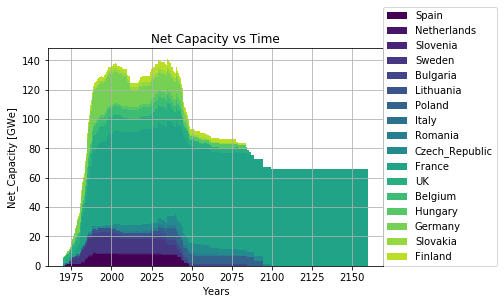

In [44]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')

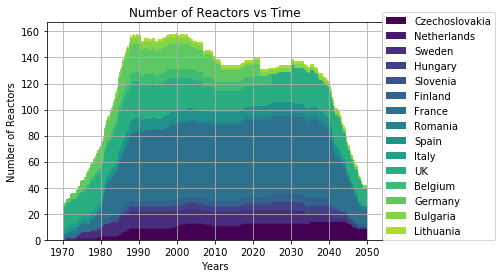

In [25]:
# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')

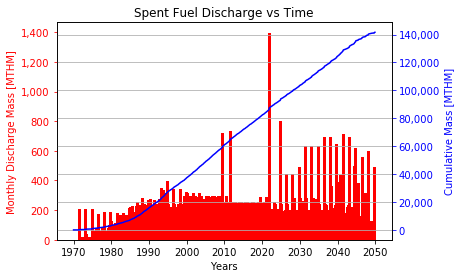

In [26]:
# Display natural U demand  vs Time
from IPython.display import Image
Image(filename='cum_mass_snf_discharge.png')

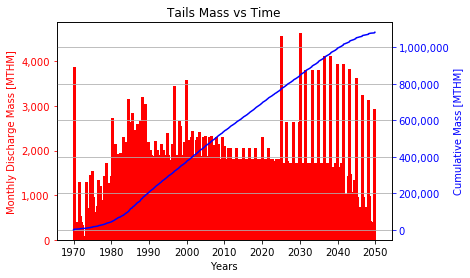

In [27]:
# Display spent fuel vs Time
from IPython.display import Image
Image(filename='tails_tailings.png')

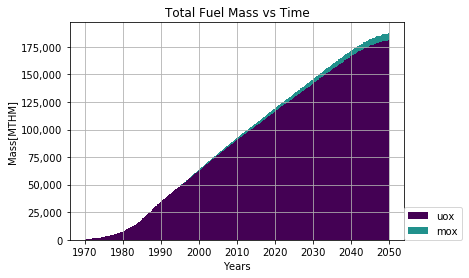

In [28]:
# Display total fuel usage  vs Time
from IPython.display import Image
Image(filename='total_fuel.png')